## Demo of Kolmogorov flow solver using JAX

### Description

The Kolmogorov flow is a periodic, turbulent flow driven by a sinusoidal forcing term. Its dynamics are governed by the Navier-Stokes equations, which can be solved in Fourier space due to the periodic nature of the flow.

In this project, a pseudospectral method is used to solve the vorticity equation (the curl of the Navier-Stokes equations) in Fourier space. The velocity components are computed with the help of a stream function. 

Consider the two-dimensional Navier-Stokes equations:

$$\begin{equation}
\partial \mathbf{u} / \partial t + (u \cdot \nabla) \mathbf{u} = -\frac{1}{\rho} \nabla P + \nu \nabla ^2 \mathbf{u}
\end{equation}
$$

taking the curl of the equation, we get the vorticity equation, where $\omega = \nabla \times \mathbf{u}$: 

$$\begin{equation}
\partial \mathbf{\omega} / \partial t + u \cdot \nabla \mathbf{\omega} = \nu \nabla ^2 \mathbf{\omega}
\end{equation}
$$

we introduce the stream function, $\Phi$, to further simplify this:

$$
\begin{equation}
    u = \nabla \times \phi 
\end{equation}
$$

$$
\begin{equation}
    \omega = - \nabla^2 \phi 
\end{equation}
$$

# Code demonstration

#### Ensure GPU is used for optimal performance

In [9]:
import jax
import jax.profiler

def check_jax_device():
    from jax.lib import xla_bridge
    device = xla_bridge.get_backend().platform
    print(f"JAX is using: {device}")

check_jax_device()

JAX is using: gpu


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from solvers import transient
from equations.flow import FlowConfig 
import equations.base as base
import equations.utils as utils 

In [13]:
# NOTE: If not using default grid_size, set gridsize in initialization:
flow = FlowConfig(grid_size=(256, 256))

# Physical parameters 
flow.Re = 250
flow.k = 4

dt = 0.001
grid = flow.create_fft_mesh()
omega_0 = flow.initialize_state()
vorticity_hat0 = omega_0

# Underlying equation
equation = base.PseudoSpectralNavierStokes2D(flow)

# Timing
end_time = 1000
# Save every x seconds 
save_time = 1
total_steps = int(end_time // dt)
step_to_save = int(save_time // dt) 

step_fn = transient.RK4_CN(equation, dt)
_, trajectory = transient.iterative_func(step_fn, vorticity_hat0, total_steps, step_to_save)
jnp.save('kolmogorov_Re_{}'.format(flow.Re), trajectory)


(256, 256)
40


### Visualize flow

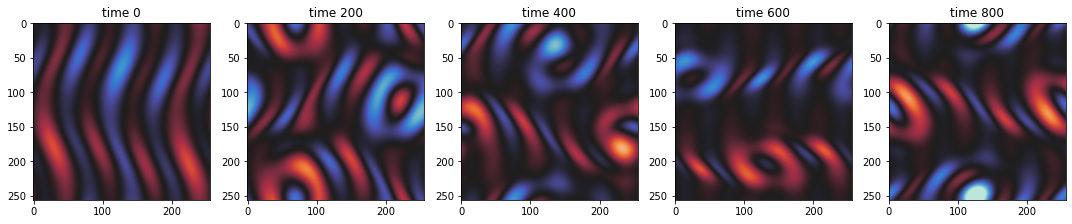

In [14]:
cols = 5
fig, axs = plt.subplots(1, cols, figsize=(15, 5))

simulation = jnp.load('kolmogorov_Re_250.npy')

data = jnp.fft.irfftn(simulation, axes=(1,2))

for i in range(cols):
    time = int(len(data) * (i/cols))
    axs[i].imshow(data[time], cmap='icefire', vmin=-8, vmax=8)
    axs[i].set_title('time {}'.format(time))

plt.tight_layout()
plt.show()

## Visualization of extreme energy event

It is known that turbulence can exhibit extreme energy events that are intermittent and often unpredictable. One example of this is Rogue waves in shallow water waves. In the case of 2D Kolmogorov flow, the extreme events are sudden bursts in energy dissipation. 

The discrete energy dissipation for an incompressible flow is calculated as: 

$$
\begin{equation}

D = 2 \nu \sum_{i,j} <\partial u_i / \partial x_j + \partial u_j / \partial x_i>^2 

\end{equation}
$$

This energy dissipation peak closely resembles similar studies, see Figure 1 in [1] and Figure 2 in [2]. 

(256, 256)
40


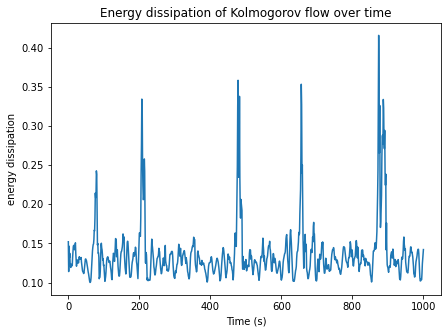

The maximum energy dissipation occurs at 874 seconds 


In [17]:
import equations.utils as utils  
import jax.numpy as jnp
import equations.flow as flow  

flow = flow.FlowConfig(grid_size=(256, 256))
trajectory = jnp.load('kolmogorov_Re_250.npy')
kx, ky = flow.create_fft_mesh()
n, m = trajectory[0].shape 
kx = kx
ky = ky

dissipation = []
plt.figure(figsize=(7,5)) 

# Compute energy dissipation for each timestep
for omega_hat in trajectory[:]:
    total_epsilon = utils.compute_energy_dissipation(omega_hat, kx, ky, flow.nu, n)    
    dissipation.append(total_epsilon)
        
plt.plot(dissipation)
plt.xlabel("Time (s)")
plt.ylabel("energy dissipation")
plt.title("Energy dissipation of Kolmogorov flow over time")
plt.show()

print("The maximum energy dissipation occurs at {} seconds ".format(dissipation.index(max(dissipation))))

## Source of extreme energy event

It was discovered in previous works [1,2] that the energy dissipation event is preceeded by a transfer of energy from a higher Fourier mode to a lower Fourier mode that has the same wavenumber as the forcing, which, in this case, is $k_y = 4$. This is validated with the below graph, which shows the energy of each mode over time. One of the energy dissipation peaks occured at 396 seconds in (see printout above). This was preceeded by the transfer of energy between mode (1,0) and (0,4), which can be demonstrated by the minimum energy of the higher Fourier mode. This occured at 365 seconds, and caused a peak in the energy of the Fourier mode with the same wavenumber as the forcing.

(256, 256)
40


/home/sajedam/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


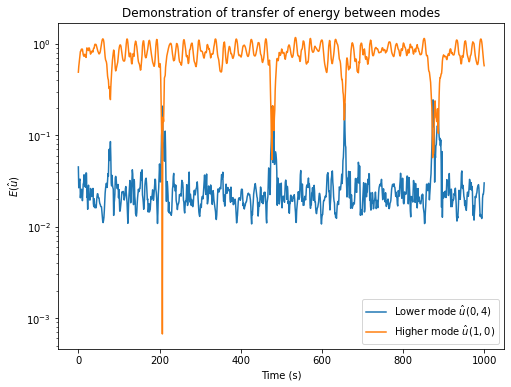

The minimum energy of the higher Fourier mode occurs at 207 seconds


In [20]:
import equations.utils as utils  
import jax.numpy as jnp

energy_04 = []
energy_10 = []
flow = flow.FlowConfig(grid_size=(256, 256))
trajectory = jnp.load('kolmogorov_Re_250.npy')
kx, ky = flow.create_fft_mesh()
n, m = trajectory[0].shape 

# Compute energy dissipation for each timestep
for omega_hat in trajectory[:]:
    uhat, vhat = utils.compute_velocity_fft(omega_hat, kx, ky)
    energy1 = utils.compute_energy_mode(uhat, vhat, 1, 0, n, m)
    energy4 = utils.compute_energy_mode(uhat, vhat, 0, 4, n, m)
    energy_04.append(energy4)
    energy_10.append(energy1)

plt.figure(figsize=(8,6))     
plt.plot(energy_04, label="Lower mode $\hat u(0, 4)$")
plt.plot(energy_10, label="Higher mode $\hat u(1, 0)$")
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("$E(\hat u )$")
plt.legend()
plt.title("Demonstration of transfer of energy between modes")
plt.show()
print("The minimum energy of the higher Fourier mode occurs at {} seconds".format(energy_10.index(min(energy_10))))


### References 

1. Gaurav Kumar, Aditya Nair, (2023). https://doi.org/10.1063/5.0180551. 

2. Mohammad Farazmand and Themistoklis P. Sapsis., (2019). DOI: 10.1103/PhysRevE.100.033110 